In [2]:
import os
import sys
#import urllib.request
import pandas as pd
import glob
import csv
import pymc3 as pm
import numpy as np
import pylab as pl

import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
#from kmeansplots import kmeans_plot, silhouette_plot

from scipy.spatial.distance import cdist
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
turnstile_all_stations = pd.read_csv('./turnstile_data_ads_1718.csv')

In [5]:
turnstile_all_stations[turnstile_all_stations['STATION'] == 'GRD CNTRL-42 ST'].shape

(249751, 11)

In [6]:
turnstile_all_stations.head()

,Unnamed: 0,C/A,UNIT,SCP,DATE,TIME,ENTRIES,DATETIME,DESC,LINENAME,STATION
0,0,R205A,R014,04-03-01,2016-12-30,23:00:00,2105940,2016-12-30 23:00:00,REGULAR,2345ACJZ,FULTON ST
1,1,N213,R154,00-00-02,2016-12-30,23:00:00,2861061,2016-12-30 23:00:00,REGULAR,BD,TREMONT AV
2,2,H041,R152,00-05-01,2016-12-30,23:00:00,262144,2016-12-30 23:00:00,REGULAR,L,CANARSIE-ROCKAW
3,3,A058,R001,01-06-01,2016-12-30,23:00:00,1253156,2016-12-30 23:00:00,REGULAR,R1W,WHITEHALL S-FRY
4,4,R230,R143,02-06-00,2016-12-30,23:00:00,39927,2016-12-30 23:00:00,REGULAR,6,28 ST


In [7]:
turnstile_all_stations['MACHINE'] = turnstile_all_stations['C/A'] +  '-' + turnstile_all_stations['UNIT'] + '-' + turnstile_all_stations['SCP']+  '-' + turnstile_all_stations['STATION'] +  '-' + turnstile_all_stations['LINENAME']

In [8]:
td = turnstile_all_stations.sort_values(by=['MACHINE' ,'DATETIME'])

In [9]:
td['ENTRY_DIFF'] = td.groupby(['MACHINE'],as_index=False)['ENTRIES'].transform(lambda x: x.diff())

In [10]:
td = td[(td['ENTRY_DIFF'] > 0) & (td['ENTRY_DIFF'] < 14400) ]

In [11]:
td['DATETIME'] = pd.to_datetime(td['DATETIME'])

In [12]:
td['HOUR'] = td['DATETIME'].dt.hour

In [407]:
gst_counts = td[td['STATION'] == 'GRD CNTRL-42 ST']
gst_counts_4hourly = gst_counts[['DATETIME' , 'ENTRY_DIFF','HOUR']].groupby(['DATETIME','HOUR']).sum()

In [343]:
gst_counts_4hourly_machine = gst_counts[['DATETIME','MACHINE' , 'ENTRY_DIFF']].groupby(['MACHINE','DATETIME' ]).sum()

### Identify top 10 subways with highest ridership:

In [324]:
top_10 = td[['STATION' , 'ENTRY_DIFF']].groupby('STATION').sum().sort_values( by = 'ENTRY_DIFF', ascending = False).head(10)

In [326]:
top_10

,ENTRY_DIFF
STATION,
GRD CNTRL-42 ST,82.423013
34 ST-PENN STA,66.662242
34 ST-HERALD SQ,65.506625
23 ST,64.449648
14 ST-UNION SQ,62.046013
TIMES SQ-42 ST,58.708610
86 ST,50.128692
125 ST,44.866891
59 ST COLUMBUS,42.967931


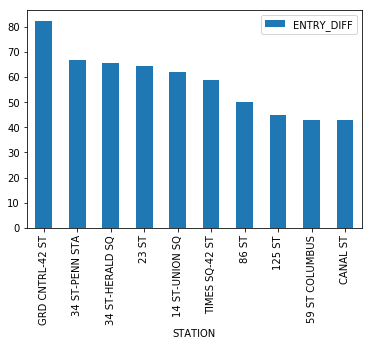

In [325]:
top_10 = top_10 / 1000000



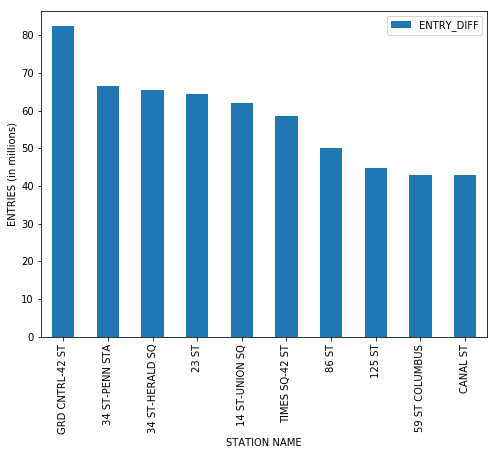

In [328]:
fig, ax = pl.subplots(figsize = (8,6))
top_10.plot(ax = ax,kind='bar')
ax.set_xlabel('STATION NAME')
ax.set_ylabel('ENTRIES (in millions)')
pl.savefig('countbars.png')

In [405]:
gst_counts_4hourly_machine.reset_index(inplace=True)

### Hierarchical Agglomerative Clustering:

In [346]:
# number of unique turnstiles in gst:
unique_turnstiles = gst_counts.MACHINE.unique().tolist()
unique_turnstiles[1]

'R236-R045-00-00-01-GRD CNTRL-42 ST-4567S'

In [347]:
#create a dataframe to 
turnstile_timeseris = pd.DataFrame()
for turnstile in unique_turnstiles:
    
    
    turnstile_df = gst_counts_4hourly_machine[['DATETIME','ENTRY_DIFF']][gst_counts_4hourly_machine['MACHINE'] == turnstile].T
    turnstile_df.columns = turnstile_df.iloc[0]
    td_inter = turnstile_df.reindex(turnstile_df.index.drop('DATETIME'))
    td_inter.rename(index={'ENTRY_DIFF': turnstile },inplace=True)
    
    turnstile_timeseris = pd.concat([turnstile_timeseris,td_inter] ,axis=0)
    

In [348]:
turnstile_timeseris.shape

(68, 3949)

In [349]:
#replace the nans with 0s and whiten the time series
turnstile_timeseris.fillna(0,axis=1,inplace=True)

vals = ((turnstile_timeseris.T - turnstile_timeseris.mean(1)) / turnstile_timeseris.std(1)).T


In [350]:
vals.head()

DATETIME,2016-12-31 03:00:00,2016-12-31 07:00:00,2016-12-31 11:00:00,2016-12-31 15:00:00,2016-12-31 19:00:00,2016-12-31 23:00:00,2017-01-01 03:00:00,2017-01-01 07:00:00,2017-01-01 11:00:00,2017-01-01 15:00:00,...,2018-12-06 11:00:00,2018-12-06 15:00:00,2018-12-06 19:00:00,2018-12-06 23:00:00,2018-12-07 03:00:00,2018-12-07 07:00:00,2018-12-07 11:00:00,2018-12-07 15:00:00,2018-12-07 19:00:00,2018-12-07 23:00:00
R236-R045-00-00-00-GRD CNTRL-42 ST-4567S,-0.495850,-0.483274,-0.335961,-0.215595,-0.174275,-0.373687,-0.443751,-0.474292,-0.456327,-0.377280,...,-0.237153,0.282037,1.611450,0.114962,-0.492257,-0.440158,-0.150921,0.467077,1.447968,-0.499443
R236-R045-00-00-01-GRD CNTRL-42 ST-4567S,-0.488709,-0.458435,-0.320039,-0.194617,-0.179480,-0.384912,-0.432486,-0.480059,-0.449785,-0.402212,...,-0.062709,0.272470,1.861863,-0.097308,-0.482222,-0.421674,-0.084333,0.361130,1.779690,-0.490872
R236-R045-00-00-02-GRD CNTRL-42 ST-4567S,-0.500474,-0.483920,-0.290003,-0.105546,-0.159937,-0.384597,-0.443718,-0.476826,-0.455542,-0.346760,...,0.256275,0.149857,1.720111,-0.200139,-0.500474,-0.365678,0.147492,0.372152,1.594774,-0.500474
R236-R045-00-00-03-GRD CNTRL-42 ST-4567S,-0.532473,-0.507321,-0.336289,-0.064651,-0.104893,-0.396654,-0.411745,-0.522412,-0.462048,-0.245743,...,1.228149,-0.125015,1.208028,-0.361441,-0.517382,-0.306107,0.755296,0.116442,0.911237,-0.532473
R236-R045-00-00-04-GRD CNTRL-42 ST-4567S,-0.527676,-0.510681,-0.319492,-0.162291,-0.141048,-0.289751,-0.387470,-0.497935,-0.417211,-0.285502,...,1.418209,-0.119805,1.328987,-0.357730,-0.523427,-0.277005,1.014587,0.037396,1.256760,-0.531925


In [351]:
#agglomerative clustering to segregate popular entry turnstiles:


agc = AgglomerativeClustering(n_clusters=14, linkage='average').fit(vals)
labelsag = agc.labels_
##centroidsag = np.zeros((17, vals.shape[1]))

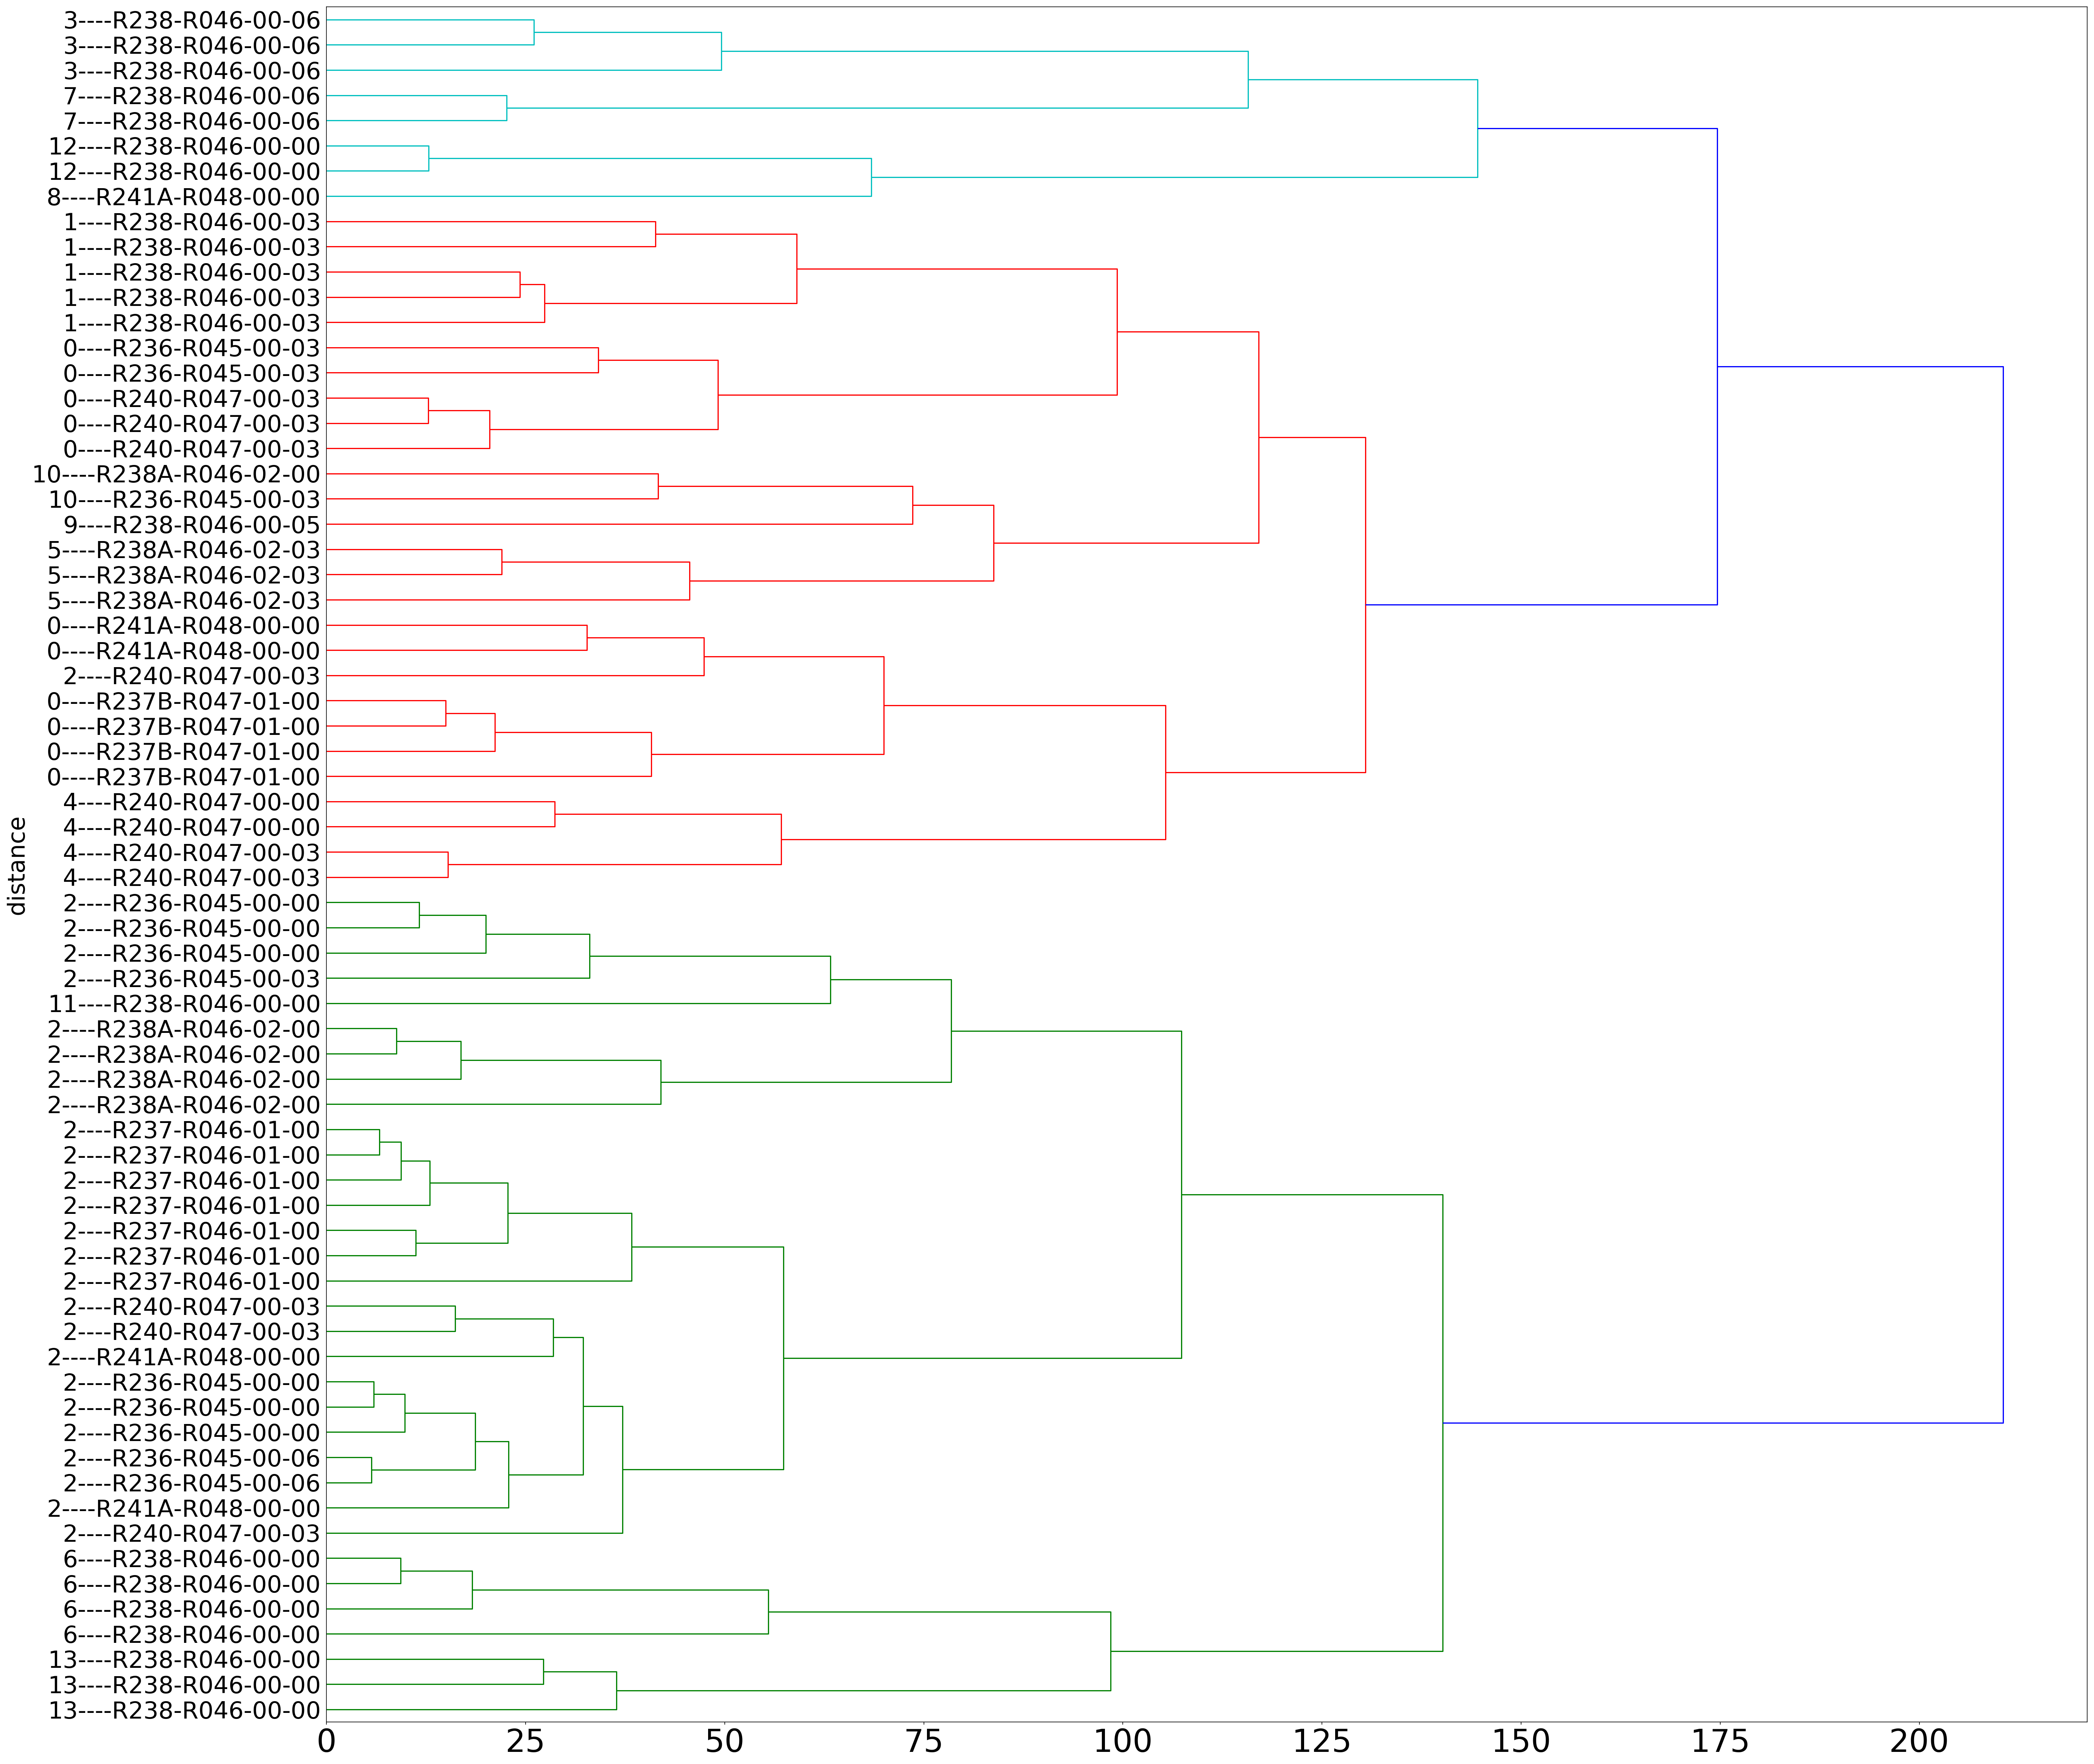

In [171]:

import scipy.cluster as scp
fig = pl.figure(figsize=(40,40), dpi=150)
pl.ylabel("distance" ,fontsize=30.0)
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = turnstiles_groups,
                               leaf_rotation=0.,  # rotates the x axis labels
                               leaf_font_size=30.,
                               orientation='right')
                               #truncate_mode='lastp')  # font size for the x axis labels)
pl.xticks(fontsize=40.)
pl.savefig('agc.png')

In [198]:
set(agc.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

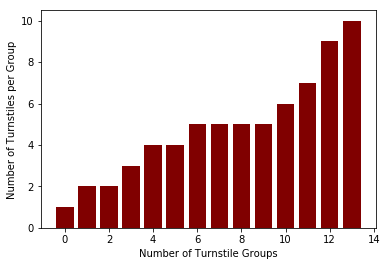

In [240]:

pl.bar(list(set(agc.labels_)),tc_count , color= 'maroon')
pl.xlabel('Number of Turnstile Groups')
pl.ylabel('Number of Turnstiles per Group')

pl.savefig('tactual.png')

In [243]:
#num_clusters = num_clusters.sort()
#num_clusters

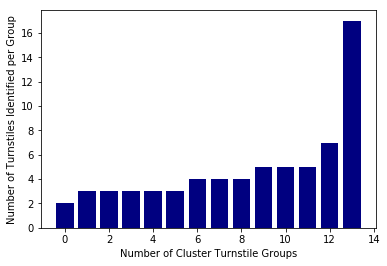

In [237]:
pl.bar(list(set(agc.labels_)),num_clusters, color = 'navy')
pl.xlabel('Number of Cluster Turnstile Groups')
pl.ylabel('Number of Turnstiles Identified per Group')

pl.savefig('tobs.png')

In [234]:
num_clusters = []
for lab in set(agc.labels_):
    #print ('There are ', sum(agc.labels_==lab), "time series in cluster", lab)
    num_clusters.append(sum(agc.labels_==lab))

In [170]:

for i in range(len(turnstiles_groups)):
    turnstiles_groups[i]  =  str(agc.labels_[i]) + '----' + turnstiles_groups[i] 

In [236]:
num_clusters.sortortort()

[2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 7, 17]

In [136]:
len(unique_turnstiles)

68

In [174]:
turnstiles_groups = []
for ut in unique_turnstiles:
    int_list = (ut.split('-')[0:4])
    turnstiles_groups.append('-'.join(int_list))
    
set(turnstiles_groups)

{'R236-R045-00-00',
 'R236-R045-00-03',
 'R236-R045-00-06',
 'R237-R046-01-00',
 'R237B-R047-01-00',
 'R238-R046-00-00',
 'R238-R046-00-03',
 'R238-R046-00-05',
 'R238-R046-00-06',
 'R238A-R046-02-00',
 'R238A-R046-02-03',
 'R240-R047-00-00',
 'R240-R047-00-03',
 'R241A-R048-00-00'}

In [214]:
tc_count = []
for tg in set(turnstiles_groups):
    print('Set of Turnstiles under ' + tg)
    count = 0
    for ut in unique_turnstiles:
        
        subts_id_list = ut.split('-')[0:4]
        subts_id = '-'.join(subts_id_list)
        if tg == subts_id:
            count = count + 1
            
            print(ut)
    print('Total number of turnstiles : ' + str(count))
    tc_count.append(count)
    print('\n')
   

Set of Turnstiles under R237B-R047-01-00
R237B-R047-01-00-00-GRD CNTRL-42 ST-4567S
R237B-R047-01-00-01-GRD CNTRL-42 ST-4567S
R237B-R047-01-00-02-GRD CNTRL-42 ST-4567S
R237B-R047-01-00-03-GRD CNTRL-42 ST-4567S
Total number of turnstiles : 4


Set of Turnstiles under R240-R047-00-03
R240-R047-00-03-00-GRD CNTRL-42 ST-4567S
R240-R047-00-03-01-GRD CNTRL-42 ST-4567S
R240-R047-00-03-02-GRD CNTRL-42 ST-4567S
R240-R047-00-03-03-GRD CNTRL-42 ST-4567S
R240-R047-00-03-04-GRD CNTRL-42 ST-4567S
R240-R047-00-03-05-GRD CNTRL-42 ST-4567S
R240-R047-00-03-06-GRD CNTRL-42 ST-4567S
R240-R047-00-03-07-GRD CNTRL-42 ST-4567S
R240-R047-00-03-08-GRD CNTRL-42 ST-4567S
Total number of turnstiles : 9


Set of Turnstiles under R238A-R046-02-03
R238A-R046-02-03-00-GRD CNTRL-42 ST-4567S
R238A-R046-02-03-01-GRD CNTRL-42 ST-4567S
R238A-R046-02-03-02-GRD CNTRL-42 ST-4567S
Total number of turnstiles : 3


Set of Turnstiles under R236-R045-00-06
R236-R045-00-06-00-GRD CNTRL-42 ST-4567S
R236-R045-00-06-01-GRD CNTRL-42 ST-

In [364]:
cluster_labels1 = pd.DataFrame(agc.labels_)
cluster_labels1.rename(columns={0 :'clusterlabel'},inplace=True)

cluster_labels1.index = vals.index
agc_df = pd.concat([vals,cluster_labels1],axis=1)

agc_df_cl1 = agc_df[agc_df['clusterlabel']== 0]
agc_df_cl1.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl2 = agc_df[agc_df['clusterlabel']== 1]
agc_df_cl2.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl3 = agc_df[agc_df['clusterlabel']== 2]
agc_df_cl3.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl4 = agc_df[agc_df['clusterlabel']== 3]
agc_df_cl4.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl5 = agc_df[agc_df['clusterlabel']== 4]
agc_df_cl5.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl6 = agc_df[agc_df['clusterlabel']== 5]
agc_df_cl6.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl7 = agc_df[agc_df['clusterlabel']== 6]
agc_df_cl7.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl8 = agc_df[agc_df['clusterlabel']== 7]
agc_df_cl8.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl9 = agc_df[agc_df['clusterlabel']== 8]
agc_df_cl9.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl10 = agc_df[agc_df['clusterlabel']== 9]
agc_df_cl10.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl11 = agc_df[agc_df['clusterlabel']== 10]
agc_df_cl11.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl12 = agc_df[agc_df['clusterlabel']== 11]
agc_df_cl12.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl13 = agc_df[agc_df['clusterlabel']== 12]
agc_df_cl13.drop('clusterlabel',axis=1,inplace=True)

agc_df_cl14 = agc_df[agc_df['clusterlabel']== 13]
agc_df_cl14.drop('clusterlabel',axis=1,inplace=True)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


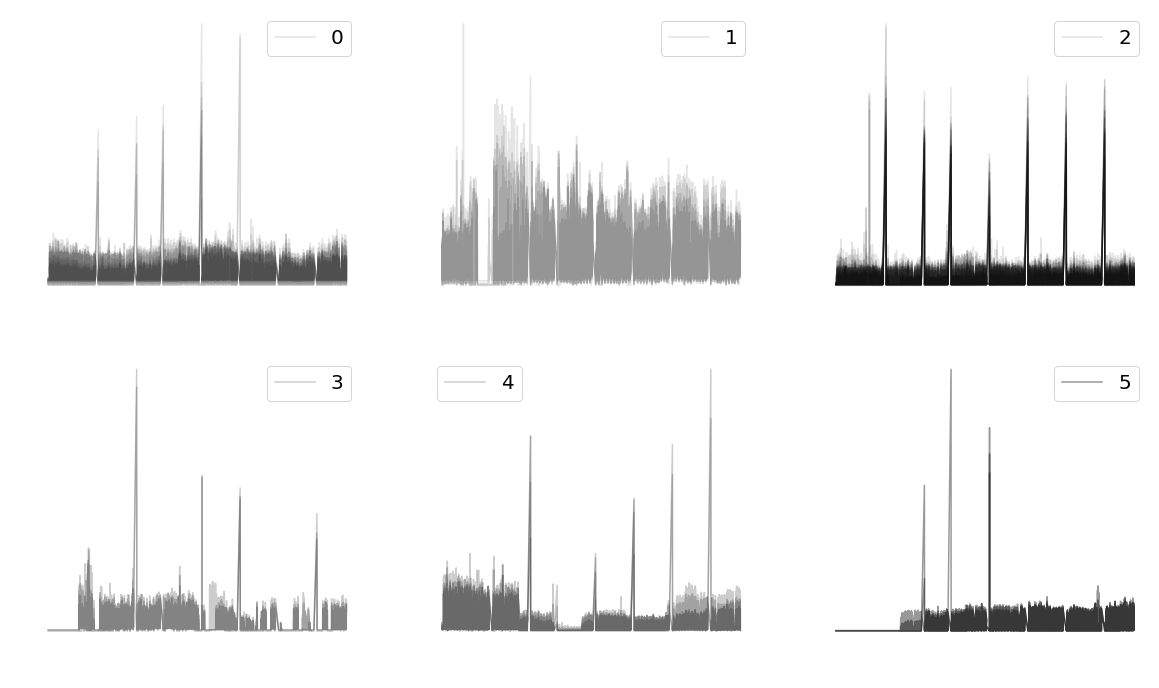

In [395]:
fig = pl.figure(figsize=(20,20))

ax1 = fig.add_subplot(331)
agc_df_cl1.T.plot(ax=ax1,legend=True,color='black' ,alpha = 0.1)
#agc_df_cl1.mean().T.plot(ax=ax1,color='navy',legend=False,alpha=0.8)
pl.axis('off')
pl.legend([0] ,fontsize=20)

ax2 = fig.add_subplot(332)
agc_df_cl2.T.plot(ax=ax2,color='black',label='False',alpha = 0.1)
#agc_df_cl2.mean().T.plot(ax=ax2,color='navy',legend=False,alpha=0.8)
pl.axis('off')
pl.legend([1] ,fontsize=20)
ax3 = fig.add_subplot(333)
agc_df_cl3.T.plot(ax=ax3,color='black',legend=False , alpha = 0.1)
#agc_df_cl3.mean().T.plot(ax=ax3,color='navy',legend=False,alpha=0.8)
pl.axis('off')
pl.legend([2] ,fontsize=20)

ax4 = fig.add_subplot(334)
agc_df_cl4.T.plot(ax=ax4, color = 'black',legend=False,alpha=0.2)
#agc_df_cl4.mean().T.plot(ax=ax4,color='navy',legend=False,alpha=0.8)
pl.axis('off')
pl.legend([3] ,fontsize=20)

ax5 = fig.add_subplot(335)
agc_df_cl5.T.plot(ax=ax5, color = 'black',legend=False,alpha=0.2)
#agc_df_cl5.mean().T.plot(ax=ax5,color='navy',legend=False,alpha=0.8)
pl.axis('off')
pl.legend([4] ,fontsize=20)


ax6 = fig.add_subplot(336)
agc_df_cl6.T.plot(ax=ax6,legend=False , color = 'black', alpha=0.4)
#agc_df_cl6.mean().T.plot(ax=ax6,color='navy',legend=False,alpha=0.5)

pl.axis('off')
pl.legend([5] ,fontsize=20)

pl.savefig('clustersagc.png')

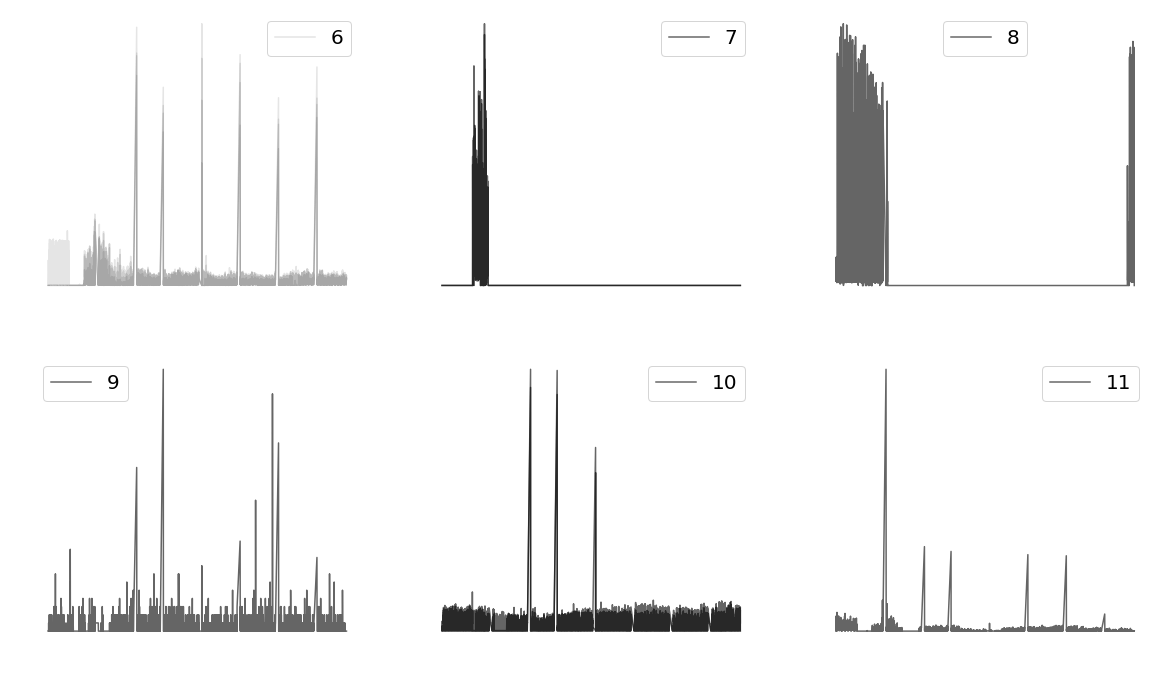

In [396]:
fig = pl.figure(figsize=(20,20))

ax1 = fig.add_subplot(331)
agc_df_cl7.T.plot(ax=ax1,color='black',legend=True,alpha=0.1)
#agc_df_cl7.mean().T.plot(ax=ax1,color='navy',legend=False,alpha=0.8)
pl.axis('off')
pl.legend([6] ,fontsize=20)

ax2 = fig.add_subplot(332)
agc_df_cl8.T.plot(ax=ax2,color='black',label='False',alpha=0.6)
#agc_df_cl8.mean().T.plot(ax=ax2,color='navy',legend=False,alpha=0.5)
pl.axis('off')
pl.legend([7] ,fontsize=20)
ax3 = fig.add_subplot(333)
agc_df_cl9.T.plot(ax=ax3,color='black',legend=False,alpha=0.6)
#agc_df_cl9.mean().T.plot(ax=ax3,color='navy',legend=False,alpha=0.5)
pl.axis('off')
pl.legend([8],fontsize=20)

ax4 = fig.add_subplot(334)
agc_df_cl10.T.plot(ax=ax4,color='black',legend=False,alpha=0.6)
#agc_df_cl10.mean().T.plot(ax=ax4,color='navy',legend=False,alpha=0.5)
pl.axis('off')
pl.legend([9],fontsize=20)

ax5 = fig.add_subplot(335)
agc_df_cl11.T.plot(ax=ax5,color='black',legend=False,alpha=0.6)
#agc_df_cl11.mean().T.plot(ax=ax5,color='navy',legend=False,alpha=0.5)
pl.axis('off')
pl.legend([10],fontsize=20)


ax6 = fig.add_subplot(336)
agc_df_cl12.T.plot(ax=ax6,legend=False,alpha=0.6,color='black')
#agc_df_cl12.mean().T.plot(ax=ax6,color='navy',legend=False,alpha=0.2)

pl.axis('off')
pl.legend([11],fontsize=20)

pl.savefig('clustersagc2.png')

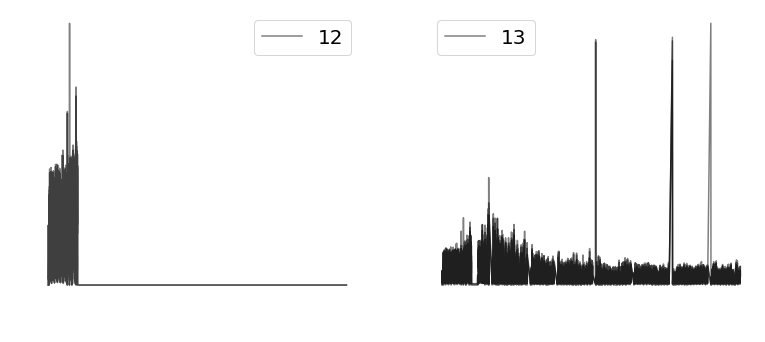

In [403]:
fig = pl.figure(figsize=(20,20))

ax1 = fig.add_subplot(331)
agc_df_cl13.T.plot(ax=ax1,color='black',legend=False,alpha=0.5)
#agc_df_cl13.mean().T.plot(ax=ax1,color='silver',legend=False,alpha=0.2)
pl.axis('off')
pl.legend([12],fontsize=20)

ax2 = fig.add_subplot(332)
agc_df_cl14.T.plot(ax=ax2,alpha=0.5,color='black')
#3agc_df_cl14.mean().T.plot(ax=ax2,color='navy',legend=False,alpha=0.5)
pl.axis('off')
pl.legend([13],fontsize=20)

pl.savefig('agcclusterfinal.png')

In [190]:
gst_counts_4hourly.reset_index(inplace=True)

# Poisson Regression Plus Time Series To Remove Impact of External Factors.

In [283]:
grouped_hours = gst_counts_4hourly.groupby('HOUR')['ENTRY_DIFF'].mean()

In [284]:
grouped_hours

HOUR
3      2210.164134
7      9484.126140
11    23328.960486
15    25509.905775
19    48914.053191
23    15791.728376
Name: ENTRY_DIFF, dtype: float64

In [285]:
grouped_hours_gst = gst_counts_4hourly.groupby('HOUR')[['ENTRY_DIFF']].mean()

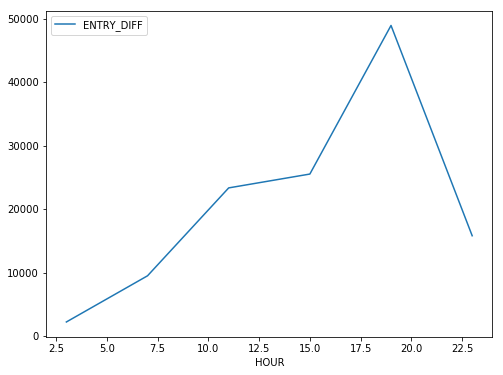

In [289]:
grouped_hours_gst.plot(figsize=(8,6))


In [413]:
gst_counts_4hourly.reset_index(inplace=True)

In [409]:
gst_counts_reduced_df = gst_counts_4hourly[['HOUR' , 'ENTRY_DIFF' ,'DATETIME']]

In [410]:
gst_counts_reduced_df.head()

,HOUR,ENTRY_DIFF,DATETIME
0,3,850.0,2016-12-31 03:00:00
1,7,971.0,2016-12-31 07:00:00
2,11,7075.0,2016-12-31 11:00:00
3,15,16020.0,2016-12-31 15:00:00
4,19,20561.0,2016-12-31 19:00:00


In [411]:
gst_counts_reduced_df.set_index('DATETIME' , inplace=True)

In [416]:
gst_counts_reduced_df.reset_index(inplace = True)

In [417]:
#gst_counts_reduced_df.reset_index(inplace=True)
gst_counts_reduced_df['WEEKNO'] = gst_counts_reduced_df['DATETIME'].dt.weekday

In [419]:
gst_counts_reduced_df['ENTRY_DIFF_std'] = (gst_counts_reduced_df['ENTRY_DIFF'] - gst_counts_reduced_df['ENTRY_DIFF'].mean()) / gst_counts_reduced_df['ENTRY_DIFF'].std()

In [293]:
grouped_weeks_gst = gst_counts_4hourly.groupby(gst_counts_4hourly['DATETIME'].dt.weekday)[['ENTRY_DIFF']].mean()

In [294]:
grouped_weeks_gst

,ENTRY_DIFF
DATETIME,
0,23411.656028
1,26012.480496
2,25962.301418
3,25875.088652
4,27588.366372
5,9768.661348
6,7472.624113


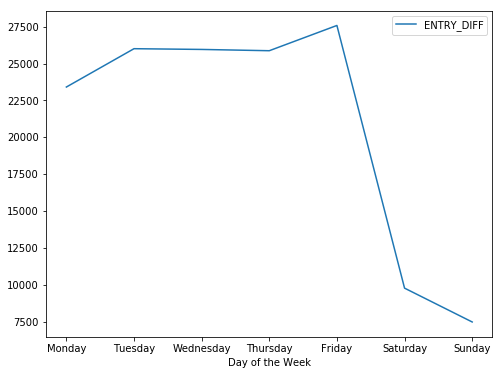

In [309]:
fig,ax= plt.subplots(figsize=(8,6))
grouped_weeks_gst.plot(ax=ax)
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(['Monday' ,'Tuesday' ,'Wednesday' ,'Thursday' ,'Friday' ,'Saturday' ,'Sunday'])
ax.set_xlabel('Day of the Week')

In [747]:
weather_data = pd.read_csv('./weather1718.csv')

In [748]:
weather_data.drop(['Unnamed: 0' ] , axis=1 , inplace=True)

In [749]:
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

In [750]:
wd_index = weather_data.set_index(['DATE' ,'HOUR'])

In [458]:
wd_index.drop(['hour' ,'isWeekday' , 'event'] ,axis=1 ,inplace=True)

In [460]:
wd_index.head()

Unnamed: 0  temperature  dewpoint  humidity  wind_speed  \
DATE       HOUR                                                            
2016-12-31 3      -1.731432    -1.391217 -1.348634 -0.555780    1.522022   
           7      -1.730606    -1.247807 -1.311932 -0.739244    0.027035   
           11     -1.729781    -0.848309 -1.261468 -1.289636    0.122997   
           15     -1.728955    -0.766361 -0.940331 -0.817872   -0.068927   
           19     -1.728130    -0.750995 -1.016028 -1.001336    0.870491   

                 pressure   precip  
DATE       HOUR                     
2016-12-31 3     0.214454 -0.20945  
           7     0.326128 -0.20945  
           11    0.002055 -0.20945  
           15   -0.223481 -0.20945  
           19   -0.348293 -0.20945

In [785]:
gst_counts_reduced_df['DATE'] = gst_counts_reduced_df['DATETIME'].dt.date
gst_counts_reduced_df['DATE'] = gst_counts_reduced_df['DATETIME'].dt.date

In [787]:
intermediate_table = gst_counts_reduced_df.set_index(['DATE' ,'HOUR'])

In [335]:
wd_index.corr()

,temperature,dewpoint,humidity,wind_speed,pressure,precip
temperature,1.000000,0.903336,0.138400,-0.353006,-0.118420,0.013953
dewpoint,0.903336,1.000000,0.542236,-0.374689,-0.162360,0.124248
humidity,0.138400,0.542236,1.000000,-0.162713,-0.137936,0.297525
wind_speed,-0.353006,-0.374689,-0.162713,1.000000,-0.079522,0.055583
pressure,-0.118420,-0.162360,-0.137936,-0.079522,1.000000,-0.101507
precip,0.013953,0.124248,0.297525,0.055583,-0.101507,1.000000


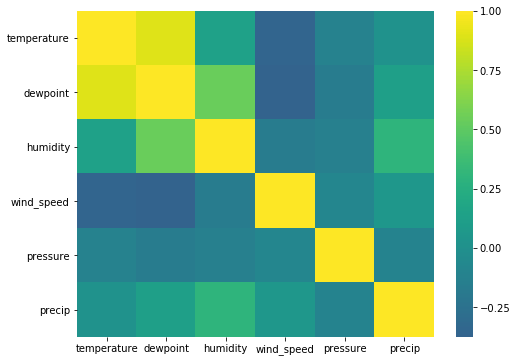

In [341]:
import seaborn as sns
plt.subplots(figsize=(8,6))
sns.heatmap(wd_index.corr(),cmap='viridis', center=0)


In [788]:
intermediate_table.head()

DATETIME  ENTRY_DIFF  WEEKNO  ENTRY_DIFF_std
DATE       HOUR                                                        
2016-12-31 3    2016-12-31 03:00:00       850.0       5       -0.905593
           7    2016-12-31 07:00:00       971.0       5       -0.900121
           11   2016-12-31 11:00:00      7075.0       5       -0.624035
           15   2016-12-31 15:00:00     16020.0       5       -0.219451
           19   2016-12-31 19:00:00     20561.0       5       -0.014061

In [789]:
merged_dat = pd.merge(wd_index,intermediate_table,left_index=True,right_index=True)

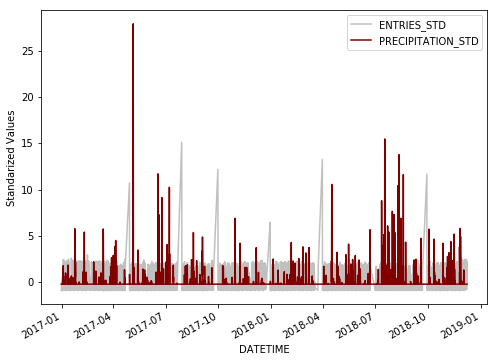

In [743]:
fig,ax = pl.subplots(figsize = (8,6))

merged_dat['ENTRY_DIFF_std'].plot(ax = ax ,label='ENTRIES_STD' ,color = 'silver')
merged_dat['precip'].plot(ax = ax,label='PRECIPITATION_STD',color = 'maroon')

ax.set_ylabel('Standarized Values')
pl.legend()

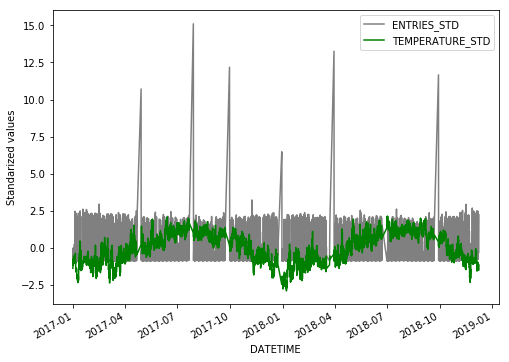

In [742]:
fig,ax = pl.subplots(figsize = (8,6))

merged_dat['ENTRY_DIFF_std'].plot(ax = ax ,label='ENTRIES_STD', color = 'grey')
merged_dat['temperature'].plot(ax = ax,label='TEMPERATURE_STD', color = 'green')
ax.set_ylabel('Standarized Values')
pl.legend()

In [790]:
merged_dat.reset_index(inplace = True)
merged_dat.set_index('DATETIME',inplace = True)
merged_dat.head()

,DATE,HOUR,temperature,dewpoint,humidity,wind_speed,pressure,precip,hour,isWeekday,event,ENTRY_DIFF,WEEKNO,ENTRY_DIFF_std
DATETIME,,,,,,,,,,,,,,
2016-12-31 03:00:00,2016-12-31,3,0.00,-8.325,54.0,14.350,1019.325,0.0,4.5,0.0,Overcast,850.0,5,-0.905593
2016-12-31 07:00:00,2016-12-31,7,1.40,-7.925,50.5,6.950,1020.600,0.0,8.5,0.0,Clear,971.0,5,-0.900121
2016-12-31 11:00:00,2016-12-31,11,5.30,-7.375,40.0,7.425,1016.900,0.0,12.5,0.0,Clear,7075.0,5,-0.624035
2016-12-31 15:00:00,2016-12-31,15,6.10,-3.875,49.0,6.475,1014.325,0.0,16.5,0.0,Scattered Clouds,16020.0,5,-0.219451
2016-12-31 19:00:00,2016-12-31,19,6.25,-4.700,45.5,11.125,1012.900,0.0,20.5,0.0,Overcast,20561.0,5,-0.014061


In [792]:
mod3 = smf.poisson(formula='ENTRY_DIFF ~ C(HOUR) + C(WEEKNO) + temperature + precip', data = merged_dat).fit()
print(mod3.summary())

Optimization terminated successfully.
         Current function value: 1742.748359
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:             ENTRY_DIFF   No. Observations:                 3909
Model:                        Poisson   Df Residuals:                     3895
Method:                           MLE   Df Model:                           13
Date:                Tue, 18 Dec 2018   Pseudo R-squ.:                  0.8047
Time:                        13:59:16   Log-Likelihood:            -6.8124e+06
converged:                       True   LL-Null:                   -3.4877e+07
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.8144      0.001   8887.818      0.000       7.813       7.816
C(HOUR)[T.7]  

In [793]:
merged_dat = pd.concat([mod3_pred ,merged_dat] , axis=1)

In [794]:
mod3_pred = pd.DataFrame(mod3.predict() ,columns= ['mod3pred'])
mod3_pred.set_index(merged_dat.index,inplace=True)


In [795]:
mod3_pred.tail()

,mod3pred
DATETIME,
2018-12-07 07:00:00,12260.759944
2018-12-07 11:00:00,30205.915054
2018-12-07 15:00:00,32972.076734
2018-12-07 19:00:00,63251.873132
2018-12-07 23:00:00,19966.537669


rmse : 17681.75543602572


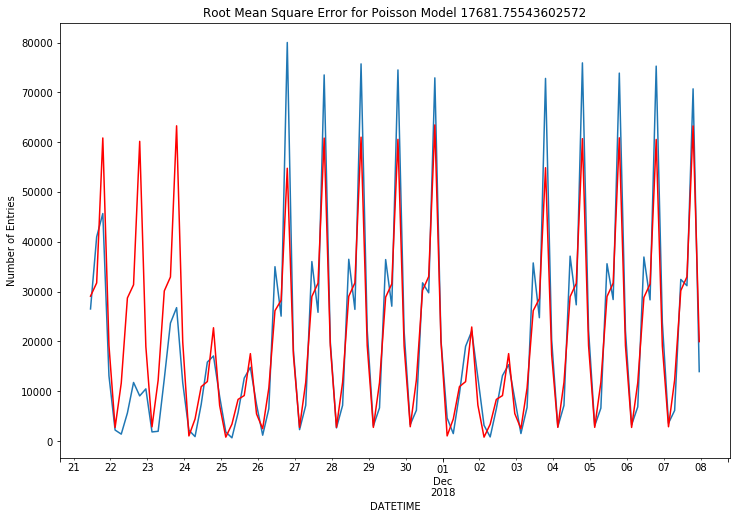

In [796]:
fig, ax = pl.subplots(figsize=(12,8))
merged_dat['ENTRY_DIFF'].tail(100).plot(ax=ax,label = 'Actual Ridership')
merged_dat['mod3pred'].tail(100).plot(ax=ax , color='red' ,label = 'Predicted Ridership')

resid3 = merged_dat['ENTRY_DIFF_std'] - merged_dat['mod3pred']
print('rmse : ' + str(np.std(resid3)))

ax.set_ylabel('Number of Entries')
ax.set_title('Root Mean Square Error for Poisson Model ' +  str(np.std(resid3)))

In [797]:
merged_dat['resid'] = mod3.resid 

In [690]:
merged_dat['resid'].tail()

DATETIME
2018-12-07 07:00:00   -6113.759944
2018-12-07 11:00:00    2240.084946
2018-12-07 15:00:00   -1784.076734
2018-12-07 19:00:00    7450.126868
2018-12-07 23:00:00   -6016.537669
Name: resid, dtype: float64

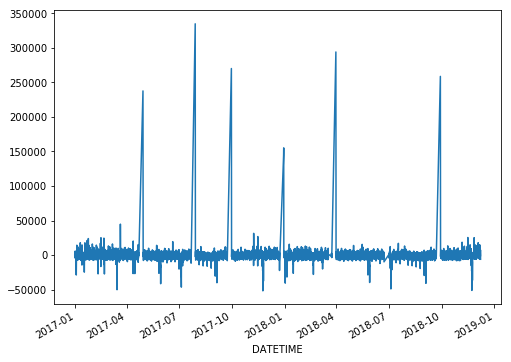

In [763]:
fig, ax = pl.subplots(figsize =(8,6))
merged_dat['resid'].plot(ax = ax)

In [692]:
entries = merged_dat['resid'][:-10]
entries_test = merged_dat['resid'][-10:]

In [693]:
entries_test

DATETIME
2018-12-06 11:00:00     8106.875693
2018-12-06 15:00:00    -3168.283487
2018-12-06 19:00:00    14714.696811
2018-12-06 23:00:00     4768.753384
2018-12-07 03:00:00      710.451488
2018-12-07 07:00:00    -6113.759944
2018-12-07 11:00:00     2240.084946
2018-12-07 15:00:00    -1784.076734
2018-12-07 19:00:00     7450.126868
2018-12-07 23:00:00    -6016.537669
Name: resid, dtype: float64

In [694]:
entries_log = np.log(entries)
entries_log_diff1 = (entries_log - entries_log.shift(6)).dropna()

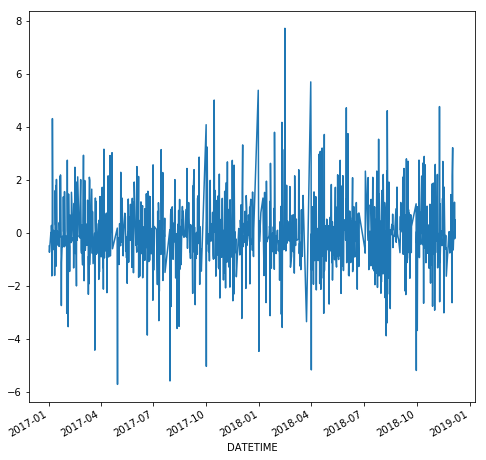

In [695]:
entries_log_diff1.plot(figsize = (8,8))

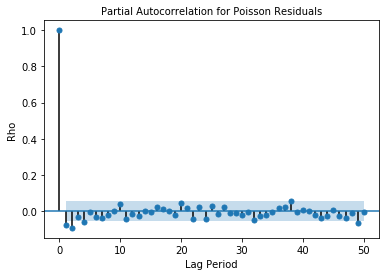

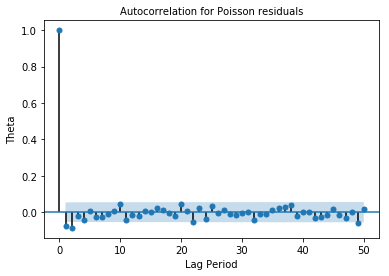

In [764]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = pl.figure(figsize=(8,6))
fig = plot_pacf(entries_log_diff1 ,lags=50)
pl.title('Partial Autocorrelation for Poisson Residuals', fontsize=10)
pl.xlabel('Lag Period')
pl.ylabel('Rho')
pl.savefig('fig2')

# autocorrealation estimate MA parameter
fig = pl.figure(figsize=(8,6))
fig = plot_acf(entries_log_diff1 , lags=50)
pl.title('Autocorrelation for Poisson residuals', fontsize=10)
pl.xlabel('Lag Period')
pl.ylabel('Theta')
pl.savefig('fig3')


In [721]:
from statsmodels.tsa.arima_model import ARIMA,ARMA

# global activ power
#for ARMA package of statsmodels use the lag of the log values to predict
# ar =1, ma =0
model1 = ARIMA(entries_log_diff1, order=(8,0,8))  
results_AR1 = model1.fit(trend='nc')  
results_AR1.summary()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  resid   No. Observations:                 1340
Model:                     ARMA(8, 8)   Log Likelihood               -2130.867
Method:                       css-mle   S.D. of innovations              1.184
Date:                Tue, 18 Dec 2018   AIC                           4295.733
Time:                        09:49:26   BIC                           4384.141
Sample:                             0   HQIC                          4328.854
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.resid    -1.2079      0.792     -1.526      0.127      -2.759       0.344
ar.L2.resid    -1.1873      0.763     -1.556      0.120      -2.683       0.308
ar.L3.resid    -1.4817      0.664     -2.232      0.026      -2.783      -0.181
ar.L4.resid    -0.7333      0.789     -0.929      0.353      -2.280       0.814
ar.L5.resid    -0.4691      0.356     -1.319      0.187      -1.166       0.228
ar.L6.resid    -0.1619      0.274     -0.592      0.554      -0.698       0.374
ar.L7.resid     0.5685      0.231      2.459      0.014       0.115       1.022
ar.L8.resid     0.1866      0.541      0.345      0.730      -0.874       1.247
ma.L1.resid     1.1123      0.787      1.413      0.158      -0.431       2.655
ma.L2.resid     0.9749      0.692      1.410      0.159      -0.381       2.330
ma.L3.resid     1.2474      0.526      2.373      0.018       0.217       2.277
ma.L4.resid     0.4353      0.677      0.643      0.520      -0.891       1.761
ma.L5.resid     0.1780      0.264      0.674      0.501      -0.340       0.696
ma.L6.resid    -0.0670      0.204     -0.328      0.743      -0.467       0.333
ma.L7.resid    -0.7721      0.294     -2.625      0.009      -1.348      -0.196
ma.L8.resid    -0.2600      0.587     -0.443      0.658      -1.410       0.890
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9803           -0.2530j            1.0125           -0.4598
AR.2           -0.9803           +0.2530j            1.0125            0.4598
AR.3           -0.2064           -0.9832j            1.0046           -0.2829
AR.4           -0.2064           +0.9832j            1.0046            0.2829
AR.5            0.4171           -0.9205j            1.0105           -0.1823
AR.6            0.4171           +0.9205j            1.0105            0.1823
AR.7            1.6214           -0.0000j            1.6214           -0.0000
AR.8           -3.1283           -0.0000j            3.1283           -0.5000
MA.1            0.4177           -0.9086j            1.0000           -0.1814
MA.2            0.4177           +0.9086j            1.0000            0.1814
MA.3            1.3502           -0.0000j            1.3502           -0.0000
MA.4           -0.2029           -0.9829j            1.0036           -0.2824
MA.5           -0.2029           +0.9829j            1.0036            0.2824
MA.6           -0.9725           -0.2503j            1.0041           -0.4599
MA.7           -0.9725           +0.2503j            1.0041            0.4599
MA.8           -2.8041           -0.0000j            2.8041           -0.5000
-----------------------------------------------------------------------------
"""

In [779]:
pd.DataFrame(results_AR1.resid).describe()

,0
count,1340.000000
mean,-0.048927
std,1.183995
min,-5.778522
25%,-0.555051
50%,-0.124668
75%,0.407175
max,7.541832


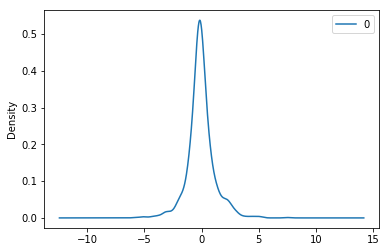

In [780]:
pd.DataFrame(results_AR1.resid).plot(kind = 'kde')

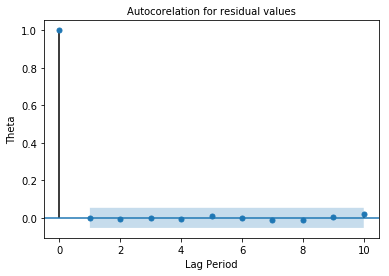

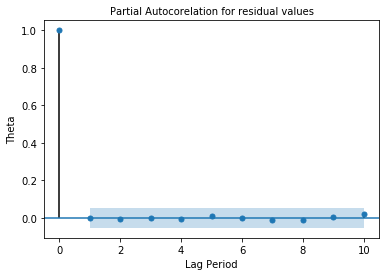

In [778]:
fig = pl.figure(figsize=(8,6))
fig = plot_acf(results_AR1.resid, lags=10)
pl.title('Autocorelation for residual values', fontsize=10)
pl.xlabel('Lag Period')
pl.ylabel('Theta')
pl.savefig('fig3')


fig = pl.figure(figsize=(8,6))
fig = plot_pacf(results_AR1.resid, lags=10)
pl.title('Partial Autocorelation for residual values', fontsize=10)
pl.xlabel('Lag Period')
pl.ylabel('Theta')
pl.savefig('fig3')

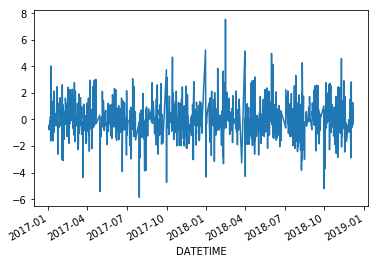

In [723]:
results_AR1.resid.plot()

#### Checking multiple parameters before choosing the final model.

In [770]:
from statsmodels.tsa.arima_model import ARIMA,ARMA

# global activ power
#for ARMA package of statsmodels use the lag of the log values to predict
# ar =1, ma =0
modelt1 = ARIMA(entries_log_diff1, order=(1,0,1))  
results_AR1 = modelt1.fit(trend='nc')  
results_AR1.summary()

diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
print(str(diff))


modelt1 = ARIMA(entries_log_diff1, order=(1,0,2))  
results_AR1 = modelt1.fit(trend='nc')  
results_AR1.summary()

diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
print(str(diff))

modelt1 = ARIMA(entries_log_diff1, order=(6,0,4))  
results_AR1 = modelt1.fit(trend='nc')  
results_AR1.summary()

diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
print(str(diff))

modelt1 = ARIMA(entries_log_diff1, order=(7,0,5))  
results_AR1 = modelt1.fit(trend='nc')  
results_AR1.summary()

diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
print(str(diff))


modelt1 = ARIMA(entries_log_diff1, order=(8,0,8))  
results_AR1 = modelt1.fit(trend='nc')  
results_AR1.summary()

diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
print(str(diff))

modelt1 = ARIMA(entries_log_diff1, order=(9,0,8))  
results_AR1 = modelt1.fit(trend='nc')  
results_AR1.summary()

diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
print(str(diff))

# calculated for [000] ,[705] ,[808]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4338411730466438


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4333244588354817


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1.4273649526359253


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1.412019098275819


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1.408110867745837


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1.4031919739103174


In [772]:
print(results_AR1.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                 1340
Model:                     ARMA(9, 8)   Log Likelihood               -2128.537
Method:                       css-mle   S.D. of innovations              1.181
Date:                Tue, 18 Dec 2018   AIC                           4293.073
Time:                        12:49:45   BIC                           4386.681
Sample:                             0   HQIC                          4328.142
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.resid    -1.6201      0.109    -14.903      0.000      -1.833      -1.407
ar.L2.resid    -1.8478      0.264     -7.003      0.000      -2.365      -1.331
ar.L3.resid    -1.7825      0.400     -4.456    

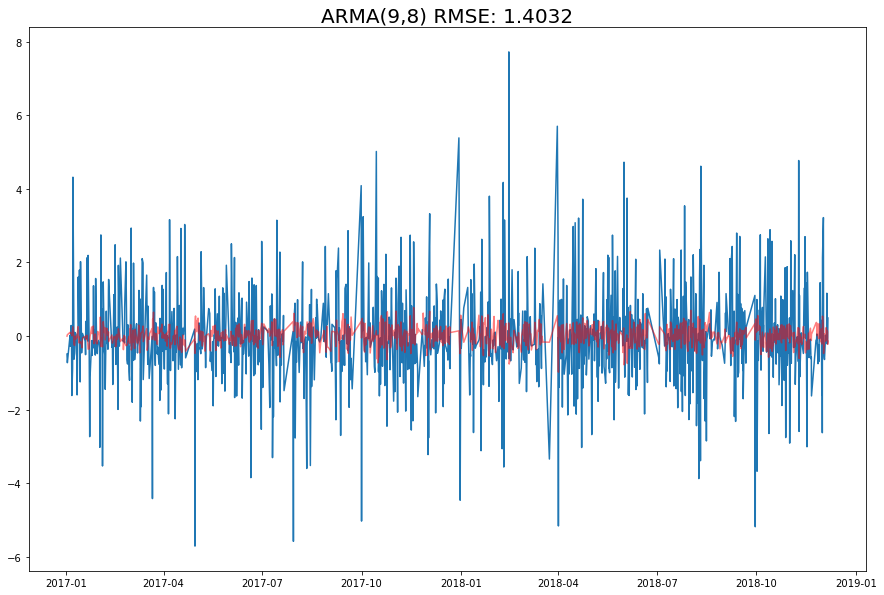

In [781]:
fig = pl.figure(figsize=(15,10))
pl.plot(entries_log_diff1)
pl.plot(results_AR1.fittedvalues, color='red',alpha=0.5)


diff = ((results_AR1.fittedvalues-entries_log_diff1)**2).mean()
pl.title('ARMA(9,8) RMSE: %.4f'% diff , fontsize=20.)
pl.savefig('fig6')

In [774]:
def inverse_difference(history, yhat, interval=6):
    y_hat_antilog = np.exp(yhat)
    return y_hat_antilog + history[-(interval)]


predictions1= []
history1 = [x for x in entries]

test_data_list1 = [x for x in entries_test]


forecast1 = results_AR1.forecast(steps=10)[0]


In [775]:
for i in range(len(forecast1)):

    yhat = inverse_difference(history1, forecast1[i])
    predictions1.append(yhat)
    # observation
    obs = test_data_list1[i]
    history1.append(obs)
    print('>Predicted=%.3f, Expected=%f' % (yhat, obs))

>Predicted=6582.473, Expected=8106.875693
>Predicted=-3289.052, Expected=-3168.283487
>Predicted=12990.286, Expected=14714.696811
>Predicted=3021.004, Expected=4768.753384
>Predicted=502.418, Expected=710.451488
>Predicted=-4834.614, Expected=-6113.759944
>Predicted=8107.904, Expected=2240.084946
>Predicted=-3166.962, Expected=-1784.076734
>Predicted=14715.672, Expected=7450.126868
>Predicted=4769.668, Expected=-6016.537669


In [776]:
predictions_series1 = pd.Series(predictions1)
predictions_series1.index = entries_test.index
predictions_series1

DATETIME
2018-12-06 11:00:00     6582.473191
2018-12-06 15:00:00    -3289.052499
2018-12-06 19:00:00    12990.285942
2018-12-06 23:00:00     3021.004247
2018-12-07 03:00:00      502.417955
2018-12-07 07:00:00    -4834.613528
2018-12-07 11:00:00     8107.903626
2018-12-07 15:00:00    -3166.961511
2018-12-07 19:00:00    14715.671725
2018-12-07 23:00:00     4769.668036
dtype: float64

RMSE: 4642.415


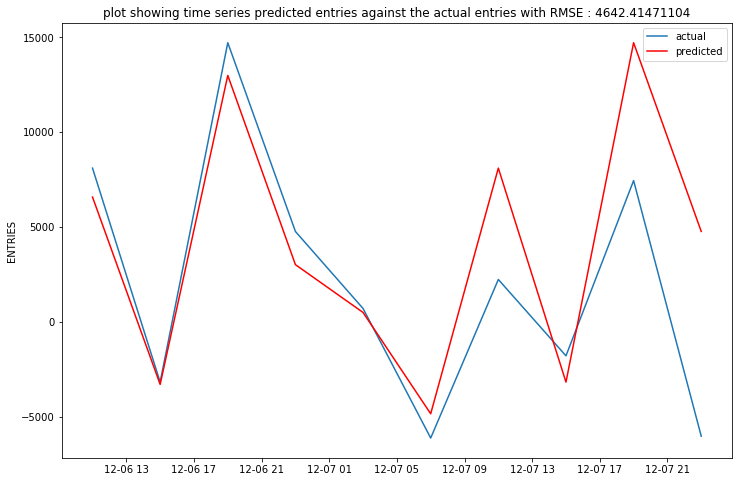

In [782]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(entries_test, predictions_series1)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)
pl.figure(figsize=(12,8))
pl.plot(entries_test,label='actual')
pl.plot(predictions_series1, color='red',label='predicted')
pl.ylabel('ENTRIES')
pl.legend()
pl.title('plot showing time series predicted entries against the actual entries with RMSE : ' + str(rmse))
pl.savefig('fig9')